# Imports

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from time import time, sleep
from datetime import timedelta

# keep matplotlib interactive
%matplotlib notebook
# %matplotlib inline
# use ggplot style
plt.style.use('ggplot')

# Data Description
Description of users log.<br>
This is a daily log of users listening to music.

|              user_logs.csv                                              |
|-------------------------------------------------------------------------|
| msno       | user id  (letters, digits and special characters)          |
| date       | format %Y%m%d                                              |
| num_25     | # of songs played less than 25% of the song length         |
| num_50     | # of songs played between 25% to 50% of the song length    |
| num_75     | # of songs played between 50% to 75% of of the song length |
| num_985    | # of songs played between 75% to 98.5% of the song length  |
| num_100    | # of songs played over 98.5% of the song length            |
| num_unq    | # of unique songs played                                   |
| total_secs | total seconds played                                       |

In [2]:
# TEMPORARY CODE FOR EXPLORATION
# user_log_dir = os.path.join(os.pardir, 'data', 'raw', 'user_logs.csv')
# Num_rows = int(20e6)

# # create file iterator
# reader_iter = pd.read_csv(user_log_dir, index_col = 'date', parse_dates=['date'], chunksize=Num_rows,\
#         usecols = ['msno', 'date', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100'])

# # get a first chunk
# df_chunk = reader_iter.get_chunk(Num_rows)

# # histogram all columns separately, np.histogram return histo and bin edges, only need histo thus [0]
# # apply columnwise (column by column or along rows) thus 0 as 2nd argument of np.histogram
# hist_num = np.apply_along_axis(lambda a: np.histogram(a, bins=bin_edges)[0], 0, df_chunk.iloc[:,1:])

## User_log

### Number of songs played and song length played

In [3]:
# create file path and compute total number of lines
user_log_dir = os.path.join(os.pardir, 'data', 'raw', 'user_logs.csv')
Total_rows = sum(1 for line in open(user_log_dir))
print('Number of rows = ', Total_rows)

Number of rows =  392106544


In [4]:
# chunk size (depends on your RAM size)
Num_rows = int(20e6)

# compile bin edges to histogram
Nbin = 1000
Ncol = 5
bin_edges = np.linspace( 0, Nbin, num=Nbin+1)
hist_num_tot = np.array(np.zeros((Nbin,Ncol)))

In [5]:
# create file iterator
reader_iter = pd.read_csv(user_log_dir, index_col = 'date', parse_dates=['date'], chunksize=Num_rows,\
        usecols = ['msno', 'date', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100'])

# get start time of timer for processing time
start_time = time()
row_counter = 0

for df_chunk in reader_iter:
    
    # histogram all log for num_x
    hist_num = np.apply_along_axis(lambda a: np.histogram(a, bins=bin_edges)[0], 0, df_chunk.iloc[:,1:])
    hist_num_tot = hist_num_tot + hist_num
    
    # get track of progress
    row_counter += df_chunk.shape[0]
    print('\r {:10.1f}%'.format(row_counter/Total_rows*100) ,end='', flush=True)

print("\n--- %s seconds ellapsed ---" % (timedelta(seconds = time() - start_time)))

      100.0%
--- 0:08:26.508834 seconds ellapsed ---


Looking at the number of songs played, each percentile played have many zeros but they may not be happening at the same time. (25, 50, 75)% share a similar trend but different amplitude. However, 98.5% and 100% are rather unique. 

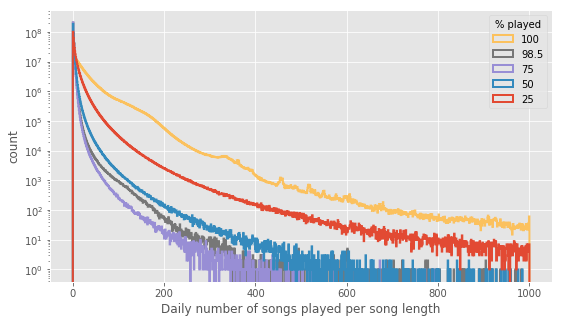

In [6]:
figax , ax = plt.subplots(figsize = (9, 5))

# extent bins to match the number of histogram
X_unit = np.tile(bin_edges[:-1], Ncol).reshape((-1,Ncol), order='F')

# prepare legend labels
legend_labels = ['25', '50', '75', '98.5', '100']

# plot histogram using weights
_ = ax.hist(X_unit, bins=bin_edges, weights=hist_num_tot, histtype='step',\
            alpha=1, linewidth = 2, label = legend_labels)

# change axis option
ax.set_yscale('log')
ax.set_ylabel('count')
ax.set_xlabel('Daily number of songs played per song length')

# add title to legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title = '% played')
figax.savefig(os.path.join(os.pardir, 'reports', 'figures', 'Songs_Percent_hist.png'))

### Number of unique song played

In [7]:
# create file iterator
reader_iter = pd.read_csv(user_log_dir, index_col = 'date', parse_dates=['date'], chunksize=Num_rows,\
        usecols = ['msno', 'date', 'num_unq'])

# compile bin edges to histogram
hist_unq_tot = np.array(np.zeros((Nbin,)))

# get start time of timer for processing time
start_time = time()
row_counter = 0

for df_chunk in reader_iter:
    
    # histogram all log for num_x
    hist_num, _ = np.histogram(df_chunk.loc[:,'num_unq'], bins=bin_edges)
    hist_unq_tot +=  hist_num
    
    # get track of progress
    row_counter += df_chunk.shape[0]
    print('\r {:10.1f}%'.format(row_counter/Total_rows*100) ,end='', flush=True)

print("\n--- %s seconds ellapsed ---" % (timedelta(seconds = time() - start_time)))

      100.0%
--- 0:06:29.063516 seconds ellapsed ---


There is at least one unique song for each entry otherwise there wouldn't be an entry.<br>
As the number of songs increases, its frequency decreases. Note there is a small peak at 100 songs.

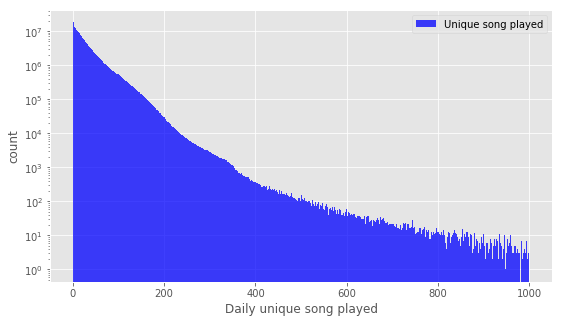

In [8]:
figunq , axunq = plt.subplots(figsize = (9, 5))

# prepare legend labels
legend_labels = ['Unique song played']

# plot histogram using weights
_ = axunq.hist(bin_edges[:-1], bins=bin_edges, weights=hist_unq_tot, histtype='bar',\
            alpha=0.75, color = 'b',label = legend_labels)

# change axis option
axunq.set_yscale('log')
axunq.set_ylabel('count')
axunq.set_xlabel('Daily unique song played')

# add title to legend
axunq.legend()
figunq.savefig(os.path.join(os.pardir, 'reports', 'figures', 'Unique_Songs_hist.png'))

### Total second played

In [9]:
# total number of bin (total seconds should not be more than 24h)
Nbin_tot = 26*60

# compute hourly bin
bin_edges_hourly = np.linspace( 0, Nbin_tot, num=int(Nbin_tot/60)+1 )

# Compute 1 min bin
bin_edges_bymin = np.linspace( 0, Nbin_tot, num=Nbin_tot+1)

In [10]:
# create file iterator
reader_iter = pd.read_csv(user_log_dir, index_col = 'date', parse_dates=['date'], chunksize=Num_rows,\
        usecols = ['msno', 'date', 'total_secs'])

# compile bin edges to histogram
hist_hourly_tot = np.array(np.zeros((len(bin_edges_hourly)-1,)))
hist_bymin_tot = np.array(np.zeros((len(bin_edges_bymin)-1,)))


# get start time of timer for processing time
start_time = time()
row_counter = 0

for df_chunk in reader_iter:
    
    # convert totat secs to total minute
    total_min = df_chunk.loc[:,'total_secs']/60
    
    # histogram log hourly and by minute
    hist_hourly, _ = np.histogram(total_min, bins=bin_edges_hourly)
    hist_hourly_tot += hist_hourly
    
    hist_bymin, _ = np.histogram(total_min, bins=bin_edges_bymin)
    hist_bymin_tot += hist_bymin
    
    # get track of progress
    row_counter += df_chunk.shape[0]
    print('\r {:10.1f}%'.format(row_counter/Total_rows*100) ,end='', flush=True)

print("\n--- %s seconds ellapsed ---" % (timedelta(seconds = time() - start_time)))

      100.0%
--- 0:07:24.224303 seconds ellapsed ---


Total minutes played aggregated by hour shows a decline in total listening time as time increases.<br>
There is a peak near 24h (relatively small, thinklog scale here). There shouldn't be any data beyond 24h as it is a daily log.<br>
Looking at the same data by minute, we can see peaks forming every 15 minutes roughly. Below 15 minutes, the most frequent time is 3-4 minutes.

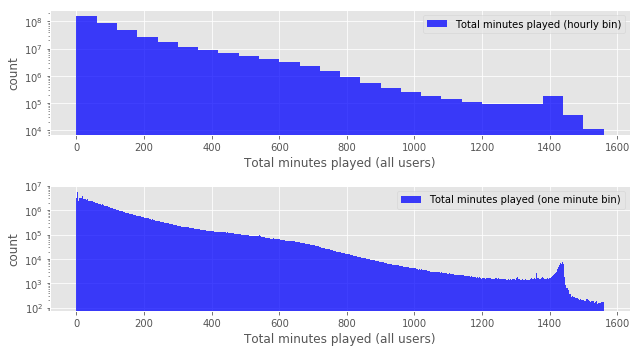

In [11]:
figtotsec , axtotsec = plt.subplots(2, 1, figsize = (9, 5))

# prepare legend labels, bin edge
legend_labels = ['Total minutes played (hourly bin)', 'Total minutes played (one minute bin)']
bin_edges_list = [bin_edges_hourly, bin_edges_bymin]
histo_list = [hist_hourly_tot, hist_bymin_tot]

# plot histogram using weights
for ax, bedge, h, l in zip(axtotsec,bin_edges_list,histo_list,legend_labels):
    _ = ax.hist(bedge[:-1], bins=bedge, weights=h, histtype='bar',\
                alpha=0.75, color = 'b', linewidth = 2, label = l)

    # change axis option
    ax.set_yscale('log')
    ax.set_ylabel('count')
    ax.set_xlabel('Total minutes played (all users)')

    # add title to legend
    ax.legend()

plt.tight_layout()
figtotsec.savefig(os.path.join(os.pardir, 'reports', 'figures', 'TotalTime_hist.png'))    

In order to gauge customer activity over time, we will look at the total seconds played as a function of time.

In [12]:
# create file iterator
reader_iter = pd.read_csv(user_log_dir, index_col = 'date', parse_dates=['date'], chunksize=Num_rows,\
        usecols = ['msno', 'date', 'total_secs'])

# empty dataframe for aggregation over total seconds
df_tot_secs = pd.DataFrame()

# get start time of timer for processing time
start_time = time()
row_counter = 0

for df_chunk in reader_iter:
    
    # get totat secs
    total_second = df_chunk.loc[:,'total_secs']
    
    # filter for negative values
    total_second = total_second[(total_second > 0) & (total_second < 24*3600)]
#     if (total_second.total_secs < 0).any():
#         total_second.total_secs[total_second.total_secs < 0].to_csv('Negative_val_{}.csv'.format(row_counter))
    
    # group by day and aggregate using sum()
    # get daily number of users too
    # pd.Grouper(level='date', freq='D')
    df_sec = total_second.groupby(level = 0).agg(['sum', 'count'])
    
    # add last time serie to global time serie
    df_tot_secs = df_tot_secs.add(df_sec, fill_value = 0)
    
    # keep track of progress
    row_counter += df_chunk.shape[0]
    print('\r {:10.1f}% done \t--- {} seconds ellapsed ---'.format(row_counter/Total_rows*100,\
                                timedelta(seconds = time() - start_time)) ,end='', flush=True)

      100.0% done 	--- 0:07:23.503102 seconds ellapsed ---

Some total values are extremely negative or positive. Obviously time cannot be negative and because there is 24h in a day, each user cannot listen for more than 24h. Those last 2 conditions are our boundaries for sanity check.<br>
We will ignore those instances at this time.

There are about 3,000+ extreme negative entries every 20 Millions rows. That's ~60,000 entries over nearly 400 millions.

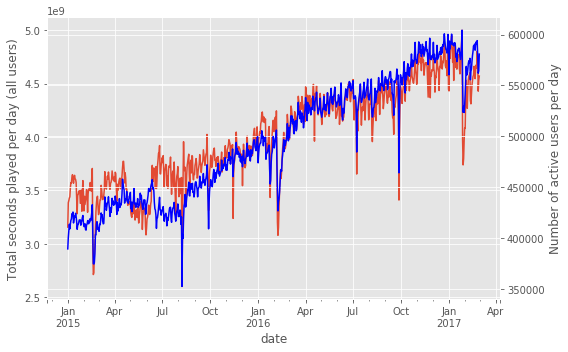

In [13]:
figact , axact = plt.subplots(figsize = (8, 5))
df_tot_secs['sum'].plot(ax = axact)
axact.set_ylabel('Total seconds played per day (all users)')

axaccact = axact.twinx()
df_tot_secs['count'].plot(ax = axaccact, color = 'b')
axaccact.set_ylabel('Number of active users per day')

plt.tight_layout()
figact.savefig(os.path.join(os.pardir, 'reports', 'figures', 'Users_Activity_TotalTime.png'))

The number of daily active users seems to correlate well with total listening time.

There are multiple drops occurring in user's count and more so in listening time. Late January drops corresponds to Chinese New Year which last 5 days not including new year's eve.<br>
Another periodic drop is on Father's day (always August 8th). Note that in 2015, father's day was on a Saturday while father's day in 2016 was on a Monday. Thus we can see a lesser drop on Sunday, August 7th in 2016<br>
Decline on September 28th, 2015 corresponds to mid-autumn festival. It does repeat in 2016 with lesser effect (September 17th).<br>
The closest event to the large drop on September 27th, 2016 was Teacher's day (birthday of Confucius) that took place on Sep. 28th, 2016.<br>
There is an extended drop in May 2015. It could be due to technical malfunction (music app not working for iphone for instance).

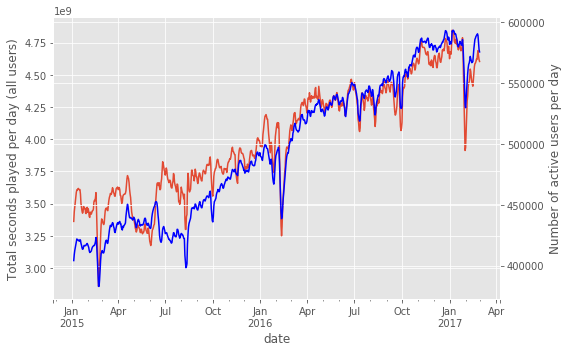

In [14]:
# Same plot but smoothed out
_ , axact2 = plt.subplots(figsize = (8, 5))
df_tot_secs_smooth = df_tot_secs.rolling(5).mean()
df_tot_secs_smooth['sum'].plot(ax = axact2)
axact2.set_ylabel('Total seconds played per day (all users)')

axaccact2 = axact2.twinx()
df_tot_secs_smooth['count'].plot(ax = axaccact2, color = 'b')
axaccact2.set_ylabel('Number of active users per day')

plt.tight_layout()

### Watermark

In [15]:
# once it is installed, you'll just need this in future notebooks:
%load_ext watermark
%watermark -a "Cedric Herman" -d -t -v -p numpy,pandas,matplotlib,seaborn,tqdm,ipywidgets

Cedric Herman 2018-03-30 14:34:21 

CPython 3.6.4
IPython 6.2.1

numpy 1.14.0
pandas 0.22.0
matplotlib 2.1.1
seaborn 0.8.1
tqdm 4.19.4
ipywidgets 7.0.0


In [16]:
# %watermark -iv